In [13]:
import tensorflow as tf
import os
import numpy as np
import sys
import random
import numpy as np

from tqdm import tqdm
from skimage.io import imread , imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [31]:
seed = 42
np.random.seed = seed

In [19]:

TRAIN_PATH = r'D:\vit\dl\image segmentation\data-science-bowl-2018\stage1_train\\'
TEST_PATH = r'D:\vit\dl\image segmentation\data-science-bowl-2018\stage1_test\\'

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS  = 3

In [20]:
training_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
X_train = np.zeros((len(training_ids) , IMG_HEIGHT , IMG_WIDTH , IMG_CHANNELS),dtype=np.uint8)
Y_train = np.zeros((len(training_ids) , IMG_HEIGHT , IMG_WIDTH , 1) , dtype = np.bool)

C:\Users\yogit\AppData\Local\Temp\ipykernel_3824\3686957717.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(training_ids) , IMG_HEIGHT , IMG_WIDTH , 1) , dtype = np.bool)


In [21]:
print('Resizing training images and masks')
for n , id_ in tqdm(enumerate(training_ids), total = len(training_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img , (IMG_HEIGHT , IMG_WIDTH) , mode = 'constant' , preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT , IMG_WIDTH , 1) , dtype = np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_ , (IMG_HEIGHT , IMG_WIDTH) ,mode = 'constant' , preserve_range=True),axis = -1)
        mask = np.maximum(mask , mask_)
    Y_train[n] = mask

Resizing training images and masks


  0%|          | 0/670 [00:00<?, ?it/s]C:\Users\yogit\AppData\Local\Temp\ipykernel_3824\4235046104.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT , IMG_WIDTH , 1) , dtype = np.bool)
100%|██████████| 670/670 [15:44<00:00,  1.41s/it]


In [22]:
#test images
X_test = np.zeros((len(test_ids) , IMG_HEIGHT , IMG_WIDTH , IMG_CHANNELS),dtype=np.uint8)
sizes_test = []
print('Resizing test images')
for n , id_ in tqdm(enumerate(test_ids), total = len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img , (IMG_HEIGHT , IMG_WIDTH) , mode = 'constant' ,preserve_range=True)
    X_test[n] = img
print("Done!")


Resizing test images


  0%|          | 0/65 [00:00<?, ?it/s]

100%|██████████| 65/65 [00:04<00:00, 15.48it/s]

Done!


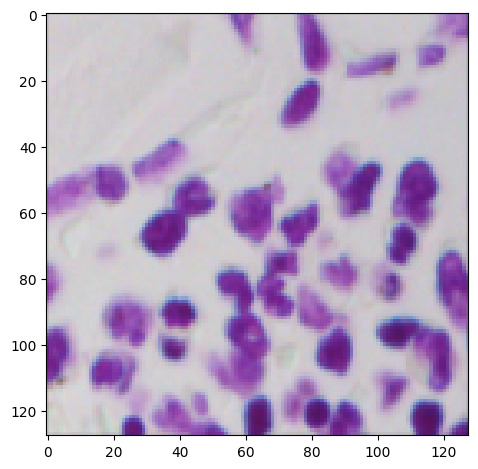

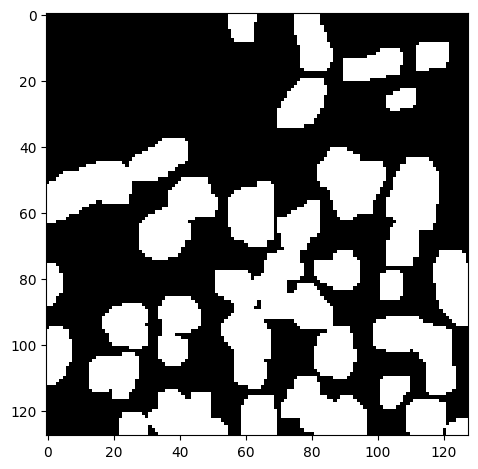

In [25]:
image_x = random.randint(0,len(training_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [24]:
# build the model

inputs = tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))

s = tf.keras.layers.Lambda(lambda x : x/255)(inputs)

#contraction path
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)


c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)


c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)


c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expansive Path

u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

#model checkpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5',save_best_only=True , verbose=1)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 4 , monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir = 'logs')
]



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [26]:
model.fit(X_train,Y_train,validation_split=0.2 , batch_size=16 , epochs=25 , callbacks=callbacks)

Epoch 1/25
34/34 [==============================] - 99s 2s/step - loss: 0.6524 - accuracy: 0.7037 - val_loss: 0.4938 - val_accuracy: 0.7627
Epoch 2/25
34/34 [==============================] - 70s 2s/step - loss: 0.6103 - accuracy: 0.7594 - val_loss: 0.4419 - val_accuracy: 0.7863
Epoch 3/25
34/34 [==============================] - 69s 2s/step - loss: 0.3824 - accuracy: 0.8041 - val_loss: 0.2814 - val_accuracy: 0.8566
Epoch 4/25
34/34 [==============================] - 68s 2s/step - loss: 0.2765 - accuracy: 0.8801 - val_loss: 0.2237 - val_accuracy: 0.9060
Epoch 5/25
34/34 [==============================] - 68s 2s/step - loss: 0.2056 - accuracy: 0.9207 - val_loss: 0.1660 - val_accuracy: 0.9340
Epoch 6/25
34/34 [==============================] - 65s 2s/step - loss: 0.1664 - accuracy: 0.9365 - val_loss: 0.1310 - val_accuracy: 0.9459
Epoch 7/25
34/34 [==============================] - 65s 2s/step - loss: 0.1520 - accuracy: 0.9420 - val_loss: 0.1282 - val_accuracy: 0.9479
Epoch 8/25
34/34 [==

In [27]:
idx = random.randint(0,len(X_train))
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)],verbose = 1)
preds_val = model.predict(X_train[:int(X_train.shape[0]*0.9):],verbose = 1)
preds_test = model.predict(X_test , verbose = 1)

3/3 [==============================] - 1s 295ms/step


In [28]:
preds_train_t = (preds_train>0.5).astype(np.uint8)
preds_val_t = (preds_val>0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

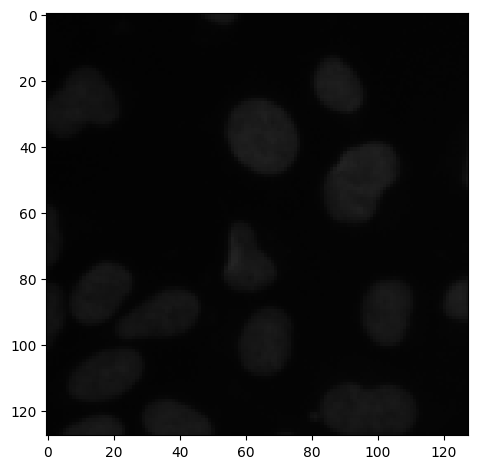

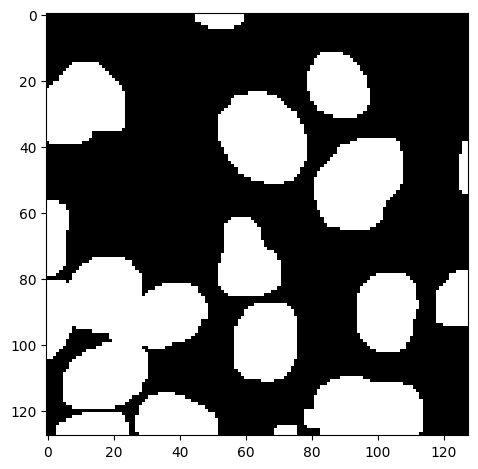

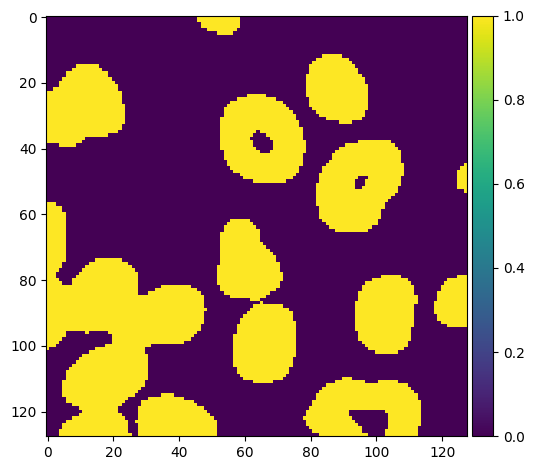

In [36]:
#perform sanity check on some random training samples
ix = random.randint(0,len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

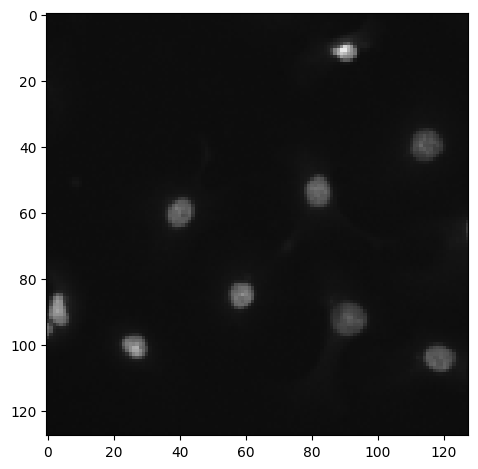

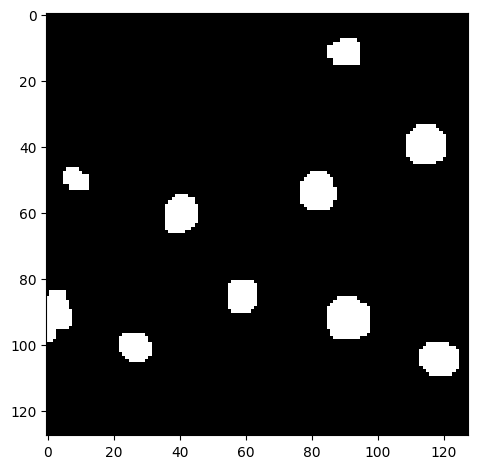

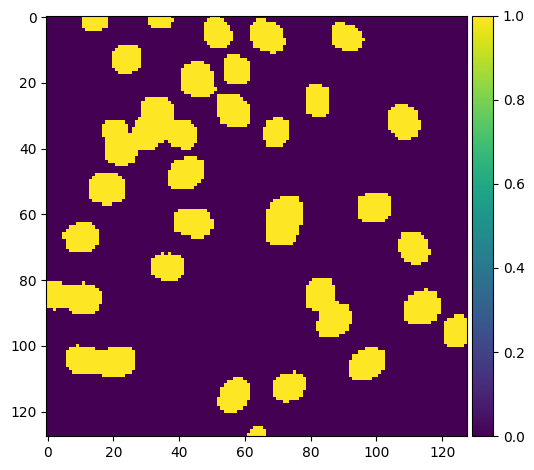

In [38]:
#perform sanity check on some random validation samples
ix = random.randint(0,67)
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()